misc notes:

clearing gpu memory: `for i in $(sudo lsof /dev/nvidia0 | grep python | awk '{print $2}' | sort -u); do sudo kill -9 $i; done`
https://github.com/tensorflow/tensorflow/issues/36465

In [1]:
%matplotlib inline

import os
from ptycho import tf_helper as hh
from ptycho import fourier as f
from ptycho import datasets
from ptycho.params import cfg
from ptycho.params import params

from sklearn.utils import shuffle

from importlib import reload
import os

import tensorflow as tf

import tensorflow_addons as tfa

import importlib
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
# from tqdm.notebook import tqdm as tqdm

from tensorflow.keras.layers import Layer
from math import pi
from tensorflow.keras import backend as K

matplotlib.rcParams['font.size'] = 12

2022-11-14 18:47:18.343270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 18:47:18.436446: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 18:47:18.773737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2022-11-14 18:47:18.773778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
!nvidia-smi

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Nov 14 18:47:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 47%   55C    P2    78W / 420W |   3123MiB / 24576MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+------------------

### Some training and probe parameters

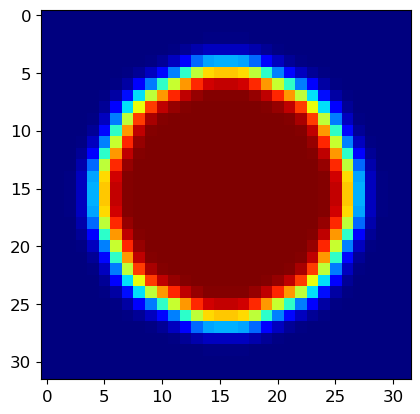

In [3]:
h = w = N = cfg['N'] = 64
# offset between neighboring scan points, in pixels
offset = cfg['offset'] = 4
gridsize = cfg['gridsize'] = 2

nepochs=20
batch_size = cfg['batch_size'] = 16

#filt = f.lowpass_g(.55, np.ones(N), sym = True)
filt = f.lowpass_g(.7, np.ones(N), sym = True)

# TODO assert symmetry
probe = f.gf(((np.einsum('i,j->ij', filt, filt)) > .5).astype(float), 1) + 1e-9
probe_small = probe[16:-16, 16:-16]
tprobe = (tf.convert_to_tensor(probe, tf.float32)[..., None])
cfg['probe'] = tprobe
tprobe_small = (tf.convert_to_tensor(probe_small, tf.float32)[..., None])

# if (not os.path.isdir(path+wt_path)):
#     os.mkdir(wt_path)

plt.imshow(tprobe_small, cmap = 'jet')

### Simulate ptychography data

In [6]:
bigoffset = (gridsize - 1) * offset + N // 2
big_gridsize = 10
bigN = params()['bigN']
size = bigoffset * (big_gridsize - 1) + bigN

from ptycho.params import params
bigoffset = cfg['bigoffset'] = ((gridsize - 1) * offset + N // 2) // 2

In [9]:
np.random.seed(1)

X_train, Y_I_train, Y_phi_train, intensity_scale, _Y_I_train_full, _  = datasets.mk_simdata(9, size, probe)
cfg['intensity_scale'] = intensity_scale

np.random.seed(2)
X_test, Y_I_test, Y_phi_test, _, _Y_I_test_full, norm_Y_I_test = datasets.mk_simdata(3, size, probe, intensity_scale)

# TODO shuffle should be after flatten
X_train, Y_I_train, Y_phi_train = shuffle(X_train.numpy(), Y_I_train.numpy(), Y_phi_train.numpy(), random_state=0)

(Y_I_test).shape, Y_I_train.shape


Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


(TensorShape([4107, 64, 64, 4]), (12321, 64, 64, 4))

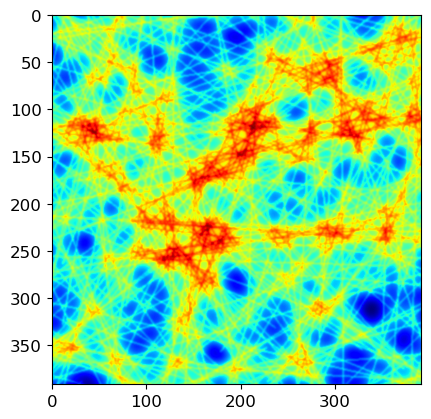

In [10]:
plt.imshow(_Y_I_train_full[0], cmap = 'jet')

In [11]:
print('intensity scale:', intensity_scale, '\n',
      'max photon count:', (np.max(Y_I_train, axis = (1, 2, 3)).mean() * intensity_scale)**2, '\n',
      'shapes:', (Y_phi_test).shape, (Y_I_test).shape, Y_I_train.shape)

intensity scale: 2531.8667011260686 
 max photon count: 4661058.100453542 
 shapes: (4107, 64, 64, 4) (4107, 64, 64, 4) (12321, 64, 64, 4)


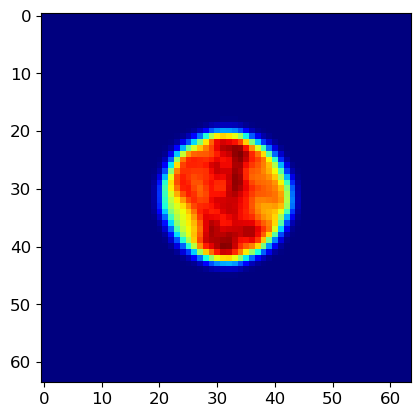

In [12]:
plt.imshow(Y_I_train[0, :, :, 0], cmap = 'jet')

### Norm conservation consistency check:

In [13]:
print(np.linalg.norm(X_train[0]) /  np.linalg.norm(Y_I_train[0]))

def normed_ff_np(arr):
    return (f.fftshift(np.absolute(f.fft2(np.array(arr)))) / np.sqrt(h * w))

1.0000068


### Inversion symmetry check:

In [14]:
assert np.isclose(normed_ff_np(Y_I_train[0, :, :, 0]),
            tf.math.conj(normed_ff_np(Y_I_train[0, ::-1, ::-1, 0])), atol = 1e-6).all()

#normed_ff_np(Y_I_train[0, :, :, 0]).sum() / normed_ff_np(Y_I_train[0, :, :, 0]).sum()

### np / tf consistency check:

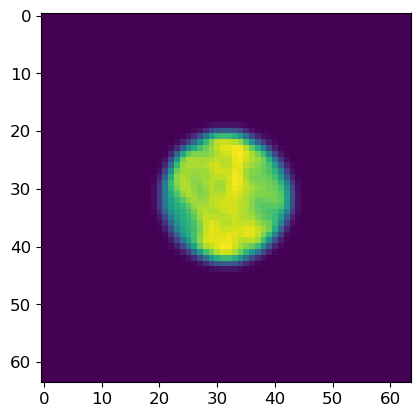

In [15]:
plt.imshow(Y_I_train[0, :, :, 0])

### Number of photons consistency check

In [16]:
np.log10(np.sum((X_train[:, :, :] * intensity_scale)**2, axis = (1, 2))).mean()

8.976986

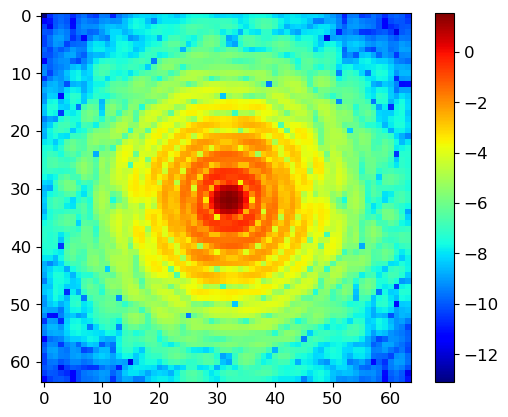

In [17]:
i = 1

plt.imshow(np.log(normed_ff_np
                  (np.array(hh.combine_complex(Y_I_train, Y_phi_train))[0, :, :, 0])), cmap = 'jet')
plt.colorbar()

/tmp/ipykernel_682357/2642748978.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_train[0, :, :, 0]), cmap = 'jet')


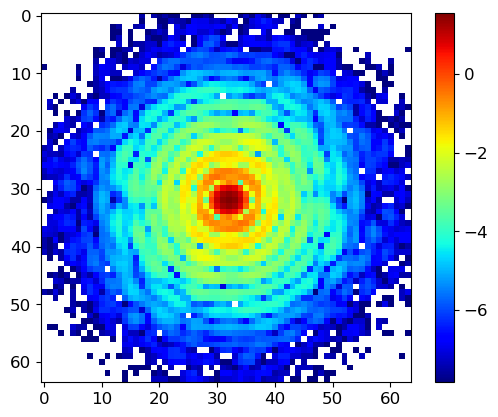

In [18]:
plt.imshow(np.log(X_train[0, :, :, 0]), cmap = 'jet')
plt.colorbar()

## Define the network structure

In [19]:
# plt.rcParams["figure.figsize"] = (10, 10)

In [20]:
# reload(model)

In [21]:
from ptycho import model

Instructions for updating:
ksizes is deprecated, use sizes instead


Instructions for updating:
ksizes is deprecated, use sizes instead


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   1184        ['input[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

None


In [22]:
X_train.shape, Y_I_train.shape

((12321, 64, 64, 4), (12321, 64, 64, 4))

In [23]:
history = model.train(40, X_train, Y_I_train)
b, a, reg, L2_error = model.autoencoder.predict([X_test])

Epoch 1/40


2022-11-14 18:50:46.567164: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


732/732 [==============================] - ETA: 0s - loss: 59111956.0000 - padded_obj_loss: 0.0981 - pred_diff_channels_loss: 0.0048 - distribution_lambda_loss: 59111956.0000 - pred_diff_channels_1_loss: 0.0375
Epoch 1: val_loss improved from inf to 39865908.00000, saving model to wts4.1/weights.01.h5
732/732 [==============================] - 12s 13ms/step - loss: 59111956.0000 - padded_obj_loss: 0.0981 - pred_diff_channels_loss: 0.0048 - distribution_lambda_loss: 59111956.0000 - pred_diff_channels_1_loss: 0.0375 - val_loss: 39865908.0000 - val_padded_obj_loss: 0.0995 - val_pred_diff_channels_loss: 0.0044 - val_distribution_lambda_loss: 39865908.0000 - val_pred_diff_channels_1_loss: 0.0401 - lr: 0.0010
Epoch 2/40
730/732 [============================>.] - ETA: 0s - loss: 19961604.0000 - padded_obj_loss: 0.0961 - pred_diff_channels_loss: 0.0038 - distribution_lambda_loss: 19961604.0000 - pred_diff_channels_1_loss: 0.0371
Epoch 2: val_loss improved from 39865908.00000 to 15055703.00000,

732/732 [==============================] - 9s 13ms/step - loss: 6024439.0000 - padded_obj_loss: 0.1428 - pred_diff_channels_loss: 0.0025 - distribution_lambda_loss: 6024439.0000 - pred_diff_channels_1_loss: 0.0371 - val_loss: 4741204.5000 - val_padded_obj_loss: 0.1461 - val_pred_diff_channels_loss: 0.0023 - val_distribution_lambda_loss: 4741204.5000 - val_pred_diff_channels_1_loss: 0.0366 - lr: 0.0010
Epoch 13/40
730/732 [============================>.] - ETA: 0s - loss: 5743876.0000 - padded_obj_loss: 0.1516 - pred_diff_channels_loss: 0.0024 - distribution_lambda_loss: 5743876.0000 - pred_diff_channels_1_loss: 0.0371
Epoch 13: val_loss improved from 4741204.50000 to 4659718.00000, saving model to wts4.1/weights.13.h5
732/732 [==============================] - 9s 13ms/step - loss: 5743063.5000 - padded_obj_loss: 0.1516 - pred_diff_channels_loss: 0.0024 - distribution_lambda_loss: 5743063.5000 - pred_diff_channels_1_loss: 0.0371 - val_loss: 4659718.0000 - val_padded_obj_loss: 0.1541 - v

Epoch 24/40
730/732 [============================>.] - ETA: 0s - loss: 2426347.0000 - padded_obj_loss: 0.1986 - pred_diff_channels_loss: 0.0018 - distribution_lambda_loss: 2426347.0000 - pred_diff_channels_1_loss: 0.0371
Epoch 24: val_loss did not improve from 2596329.00000
732/732 [==============================] - 9s 12ms/step - loss: 2426132.5000 - padded_obj_loss: 0.1986 - pred_diff_channels_loss: 0.0018 - distribution_lambda_loss: 2426132.5000 - pred_diff_channels_1_loss: 0.0371 - val_loss: 2669156.5000 - val_padded_obj_loss: 0.1976 - val_pred_diff_channels_loss: 0.0019 - val_distribution_lambda_loss: 2669156.5000 - val_pred_diff_channels_1_loss: 0.0366 - lr: 2.5000e-04
Epoch 25/40
728/732 [============================>.] - ETA: 0s - loss: 2379480.0000 - padded_obj_loss: 0.1992 - pred_diff_channels_loss: 0.0018 - distribution_lambda_loss: 2379480.0000 - pred_diff_channels_1_loss: 0.0371
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 25: val_los

732/732 [==============================] - 9s 13ms/step - loss: 1977707.6250 - padded_obj_loss: 0.2015 - pred_diff_channels_loss: 0.0017 - distribution_lambda_loss: 1977707.6250 - pred_diff_channels_1_loss: 0.0371 - val_loss: 2190458.0000 - val_padded_obj_loss: 0.1996 - val_pred_diff_channels_loss: 0.0017 - val_distribution_lambda_loss: 2190458.0000 - val_pred_diff_channels_1_loss: 0.0365 - lr: 1.2500e-04
Epoch 36/40
730/732 [============================>.] - ETA: 0s - loss: 1950609.8750 - padded_obj_loss: 0.2016 - pred_diff_channels_loss: 0.0017 - distribution_lambda_loss: 1950609.8750 - pred_diff_channels_1_loss: 0.0371
Epoch 36: val_loss improved from 2190458.00000 to 2178797.50000, saving model to wts4.1/weights.36.h5
732/732 [==============================] - 9s 12ms/step - loss: 1950731.3750 - padded_obj_loss: 0.2016 - pred_diff_channels_loss: 0.0017 - distribution_lambda_loss: 1950731.3750 - pred_diff_channels_1_loss: 0.0371 - val_loss: 2178797.5000 - val_padded_obj_loss: 0.2002

In [35]:
# %timeit diffraction_to_obj.predict([X_test])

4/4 [==============================] - 0s 3ms/step
35.8 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# %timeit autoencoder.predict([X_test])

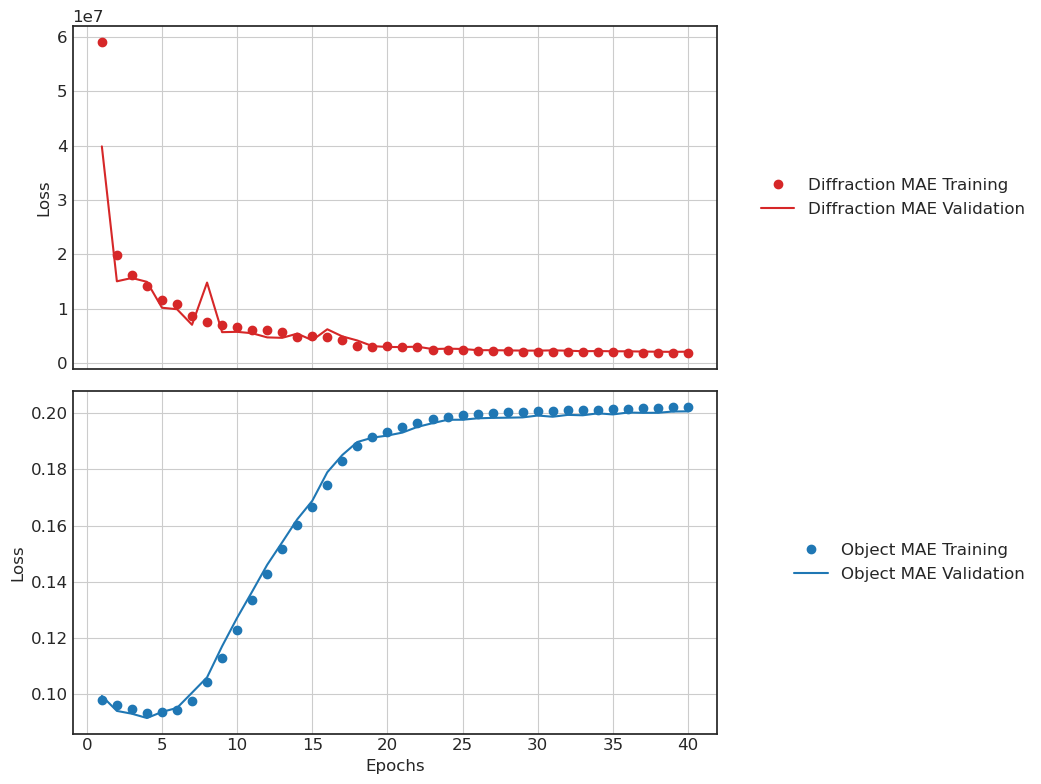

In [25]:
from ptycho import evaluation
reload(evaluation)

evaluation.plt_metrics(history)

/home/ollie/Documents/scratch/ptycho/ptycho/evaluation.py:49: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


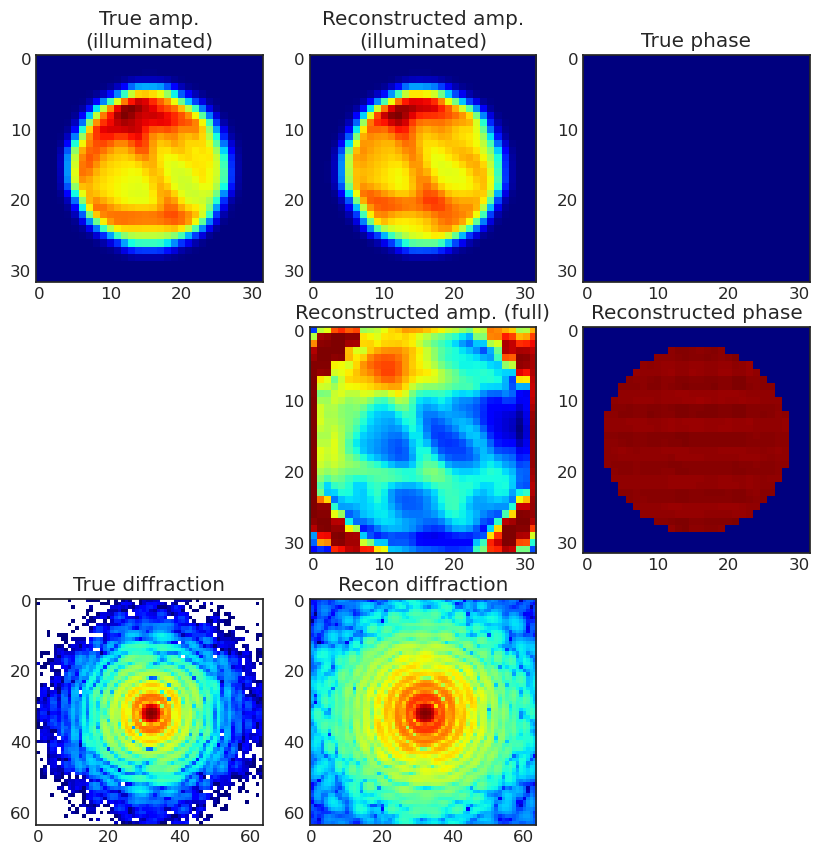

In [26]:
#plt_metrics()
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

## Evaluate resolution

In [234]:
np.random.seed(2)
Y_I_2, Y_phi_2, _Y_I_full_2 = simulate_objects(12)

line = np.zeros_like(Y_I_2)
line[:, 31, :, :] = .1
line = f.gf(line, (0, 1, 1, 0))

X_2, Y_I_2, Y_phi_2, _ =\
    illuminate_and_diffract(Y_I_2 + line, Y_phi_2, intensity_scale = intensity_scale)

plt.imshow((Y_I_2 - Y_I_test)[0, :, :, 0])
plt.colorbar()

b2, _, _, _ = autoencoder.predict([X_2])
difference = np.real(b2 - b).mean(axis = 0)

plt.imshow(difference, cmap = 'jet')

lineout_orig = line[0, :, :, 0].sum(axis = 1)
lineout_recon = difference[:, :, 0].sum(axis = 1)

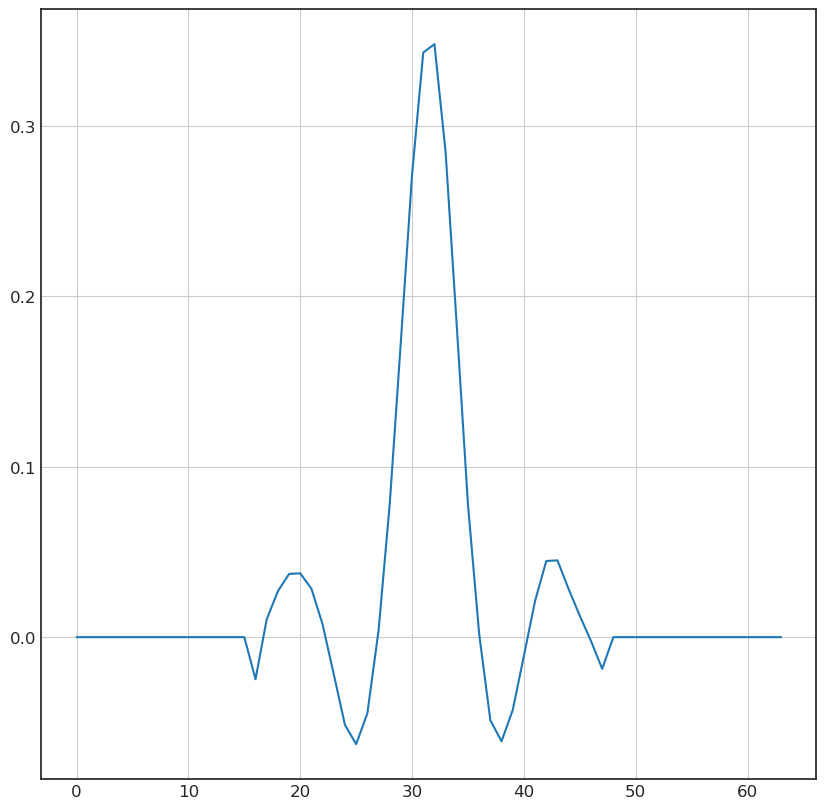

In [251]:
%matplotlib inline
#plt.plot(lineout_orig)
plt.plot(lineout_recon)
plt.grid()

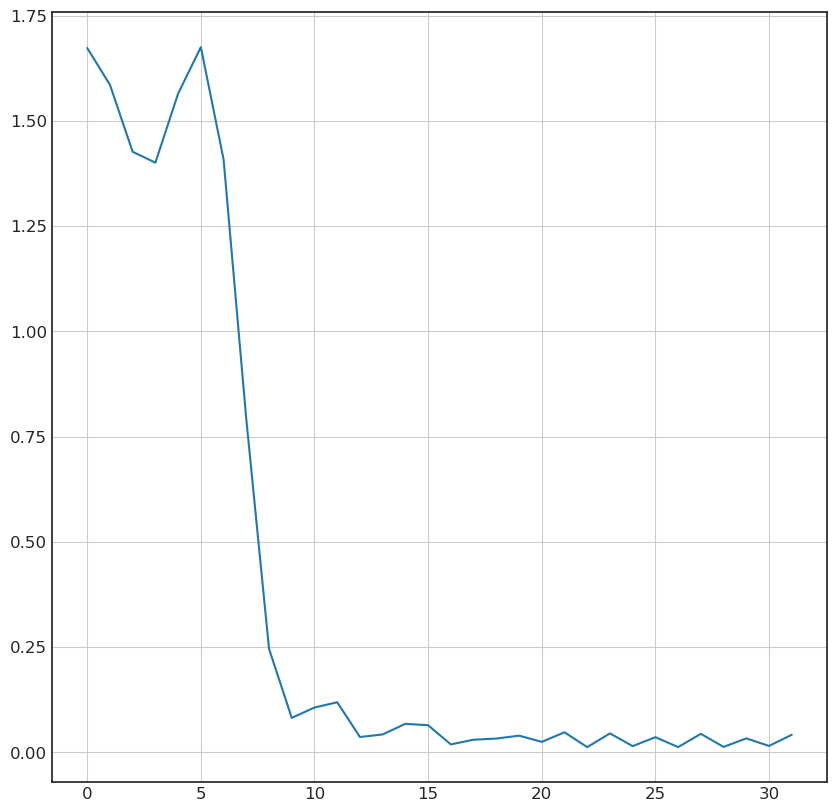

In [253]:
plt.plot(np.abs(f.fftshift(f.fft(lineout_recon)))[32:])
# plt.plot(np.abs(f.fftshift(f.fft(lineout_orig)))[32:])
plt.grid()

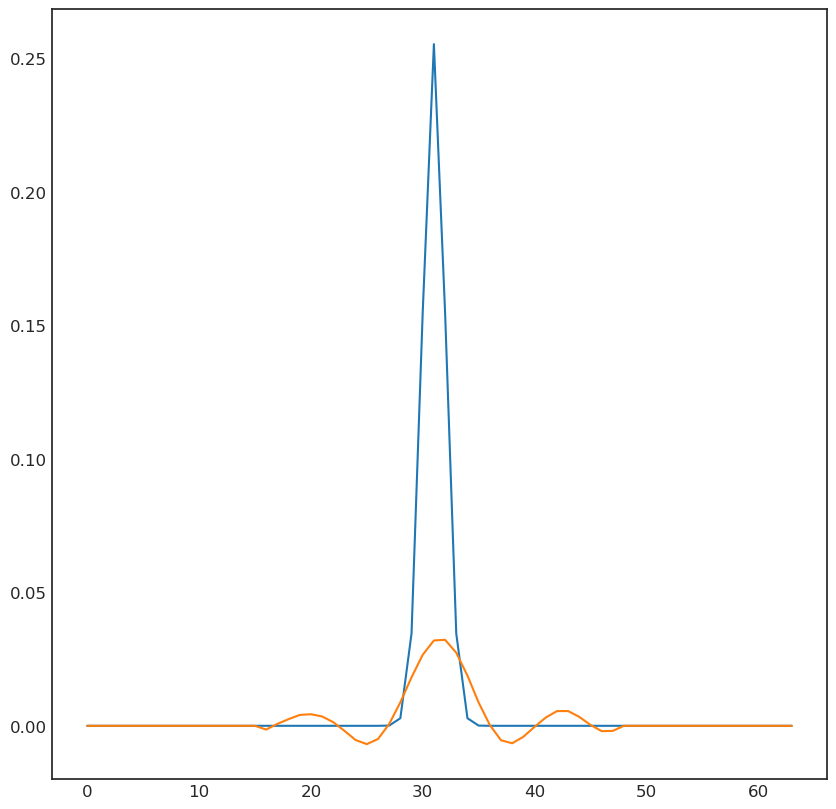

In [205]:
lineout_orig = line[0, :, :, 0].sum(axis = 1)

lineout_recon = difference[:, :, 0].sum(axis = 1)

plt.plot(lineout_orig)
plt.plot(lineout_recon)

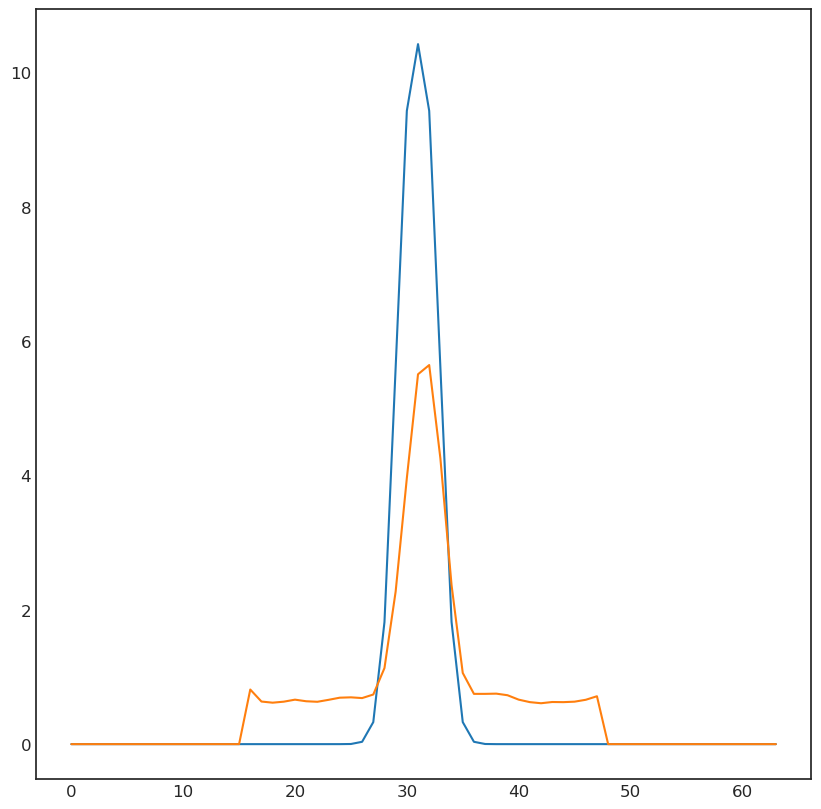

In [97]:
lineout_orig = line[0, :, :, 0].sum(axis = 1)

lineout_recon = difference[:, :, 0].sum(axis = 1)

plt.plot(lineout_orig)
plt.plot(lineout_recon)

In [27]:
from ptycho import baselines as bl
from ptycho.params import params

In [28]:
bigoffset = params()['bigoffset']

bordersize = N // 2 - bigoffset // 4
clipsize = (bordersize + ((gridsize - 1) * offset) // 2)

def stitch(b, norm_Y_I_test = 1, nsegments = big_gridsize * 2 - 1):
    img_recon = np.reshape((norm_Y_I_test * np.absolute(b)), (-1, nsegments,
                                                              nsegments, 64, 64, 1))
    img_recon = img_recon[:, :, :, bordersize: -bordersize, bordersize: -bordersize, :]
    tmp = img_recon.transpose(0, 1, 3, 2, 4, 5)
    stitched = tmp.reshape(-1, np.prod(tmp.shape[1:3]), np.prod(tmp.shape[1:3]), 1)
    return stitched

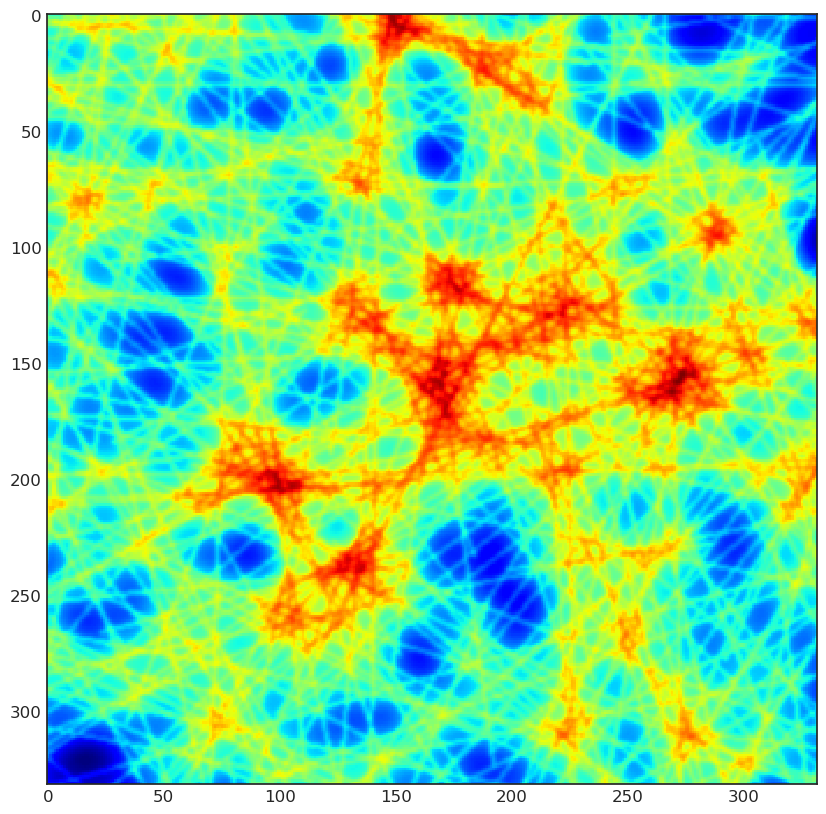

In [29]:
bordersize = N // 2 - bigoffset // 4
clipsize = (bordersize + ((gridsize - 1) * offset) // 2)

plt.imshow(_Y_I_test_full[0, clipsize: -clipsize, clipsize: -clipsize], interpolation = 'none',
          cmap = 'jet')
vmin = np.min(_Y_I_test_full[0, clipsize: -clipsize, clipsize: -clipsize])
vmax = np.max(_Y_I_test_full[0, clipsize: -clipsize, clipsize: -clipsize])

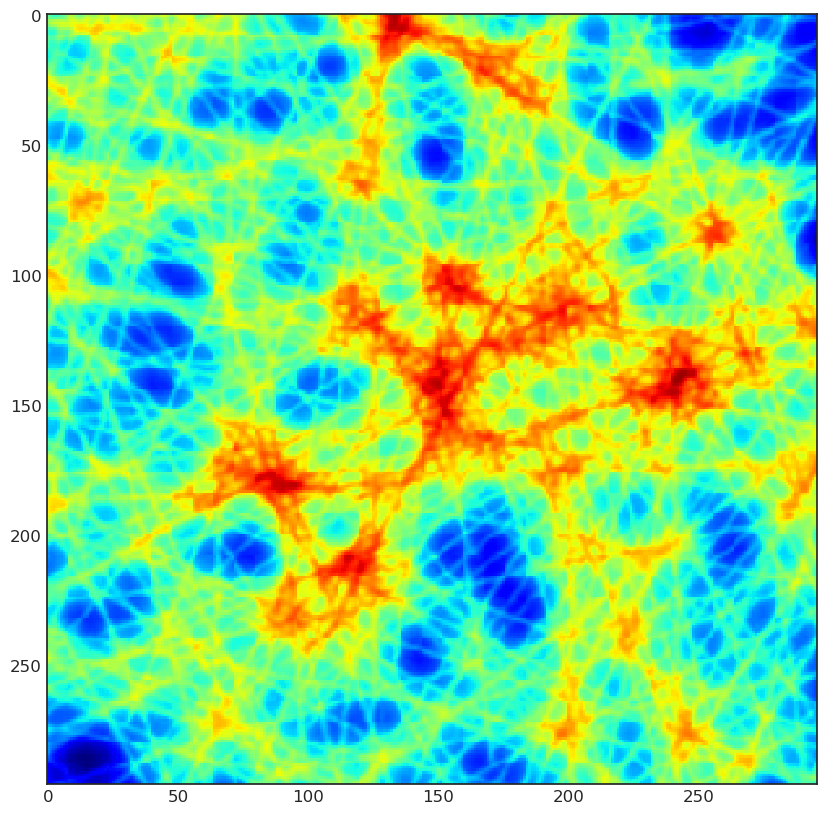

In [30]:
plt.rcParams["figure.figsize"] = (10, 10)

stitched = stitch(b, norm_Y_I_test, nsegments=37)

plt.imshow(stitched[0], interpolation = 'none', vmin = vmin, vmax = vmax, cmap = 'jet')

In [34]:
bl.nepochs = 20

In [35]:
baseline_model = bl.train((X_train[:, :, :, :1]), Y_I_train[:, :, :, :1], Y_phi_train[:, :, :, :1])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

Epoch 8/20
366/366 [==============================] - 5s 13ms/step - loss: 0.0058 - conv2d_12_loss: 0.0058 - conv2d_19_loss: 4.7005e-05 - val_loss: 0.0060 - val_conv2d_12_loss: 0.0059 - val_conv2d_19_loss: 5.7063e-05 - lr: 5.0000e-04
Epoch 9/20
366/366 [==============================] - 5s 13ms/step - loss: 0.0058 - conv2d_12_loss: 0.0058 - conv2d_19_loss: 4.7237e-05 - val_loss: 0.0057 - val_conv2d_12_loss: 0.0057 - val_conv2d_19_loss: 1.0451e-05 - lr: 5.0000e-04
Epoch 10/20
366/366 [==============================] - 5s 13ms/step - loss: 0.0058 - conv2d_12_loss: 0.0058 - conv2d_19_loss: 4.7158e-05 - val_loss: 0.0059 - val_conv2d_12_loss: 0.0058 - val_conv2d_19_loss: 1.1731e-04 - lr: 5.0000e-04
Epoch 11/20
366/366 [==============================] - ETA: 0s - loss: 0.0058 - conv2d_12_loss: 0.0058 - conv2d_19_loss: 4.7479e-05
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
366/366 [==============================] - 5s 12ms/step - loss: 0.0058 - conv2d_12_loss:

129/129 [==============================] - 1s 4ms/step


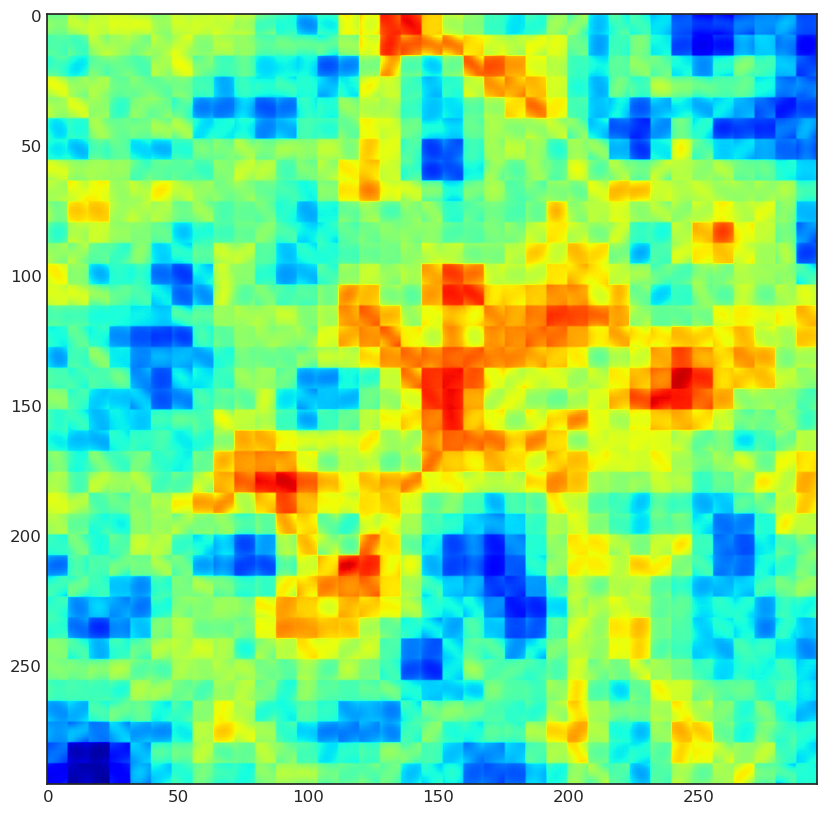

In [36]:
baseline_pred_I, baseline_pred_phi = baseline_model.predict([X_test[:, :, :, 0]])
baseline_stitched = stitch(baseline_pred_I, norm_Y_I_test, nsegments=37)

plt.imshow(baseline_stitched[0], cmap = 'jet', vmin = vmin, vmax = vmax)

In [47]:
# gt = _Y_I_test_full[:, clipsize: -clipsize, clipsize: -clipsize]
# tf.keras.losses.MeanAbsoluteError()(gt, stitched)

In [48]:
# tf.keras.losses.MeanSquaredError()(gt, stitched)

In [49]:
# tf.keras.losses.MeanAbsoluteError()(gt, baseline_stitched)

In [88]:
# tf.keras.losses.MeanSquaredError()(gt, baseline_stitched)

<tf.Tensor: shape=(), dtype=float32, numpy=0.00013008271>

In [50]:
baseline_model.evaluate([X_test[:, :, :, 0]])

129/129 [==============================] - 0s 641us/step - loss: 0.0000e+00 - conv2d_12_loss: 0.0000e+00 - conv2d_19_loss: 0.0000e+00


[0.0, 0.0, 0.0]

In [51]:
i = 0
# consistency check: should be close to equal
np.sum(tf.math.abs(a[i])**2), np.sum(tf.math.abs(X_test[i])**2),\
np.sum(tf.math.abs(a)**2), np.sum(tf.math.abs(X_test)**2)

(1187.3422, 1185.133, 4194472.5, 4196112.0)

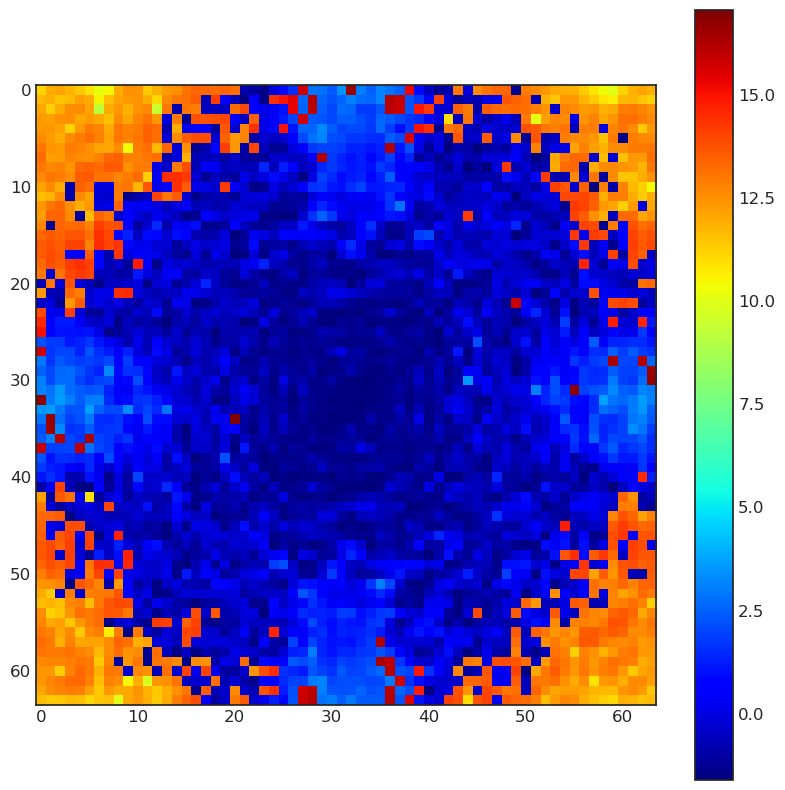

In [52]:
plt.imshow(np.log(.2 + np.abs((a[i, :, :, 0] - X_test[i, :, :, 0]) / (X_test[i, :, :, 0] + 1e-9))), cmap ='jet')
plt.colorbar()

In [39]:
# !ln ../xrd_clustering/notebooks/visualization.py
from ptycho import visualization as vis
reload(vis)

<module 'ptycho.visualization' from '/home/ollie/Documents/scratch/ptycho/ptycho/visualization.py'>

diffraction reconstruction


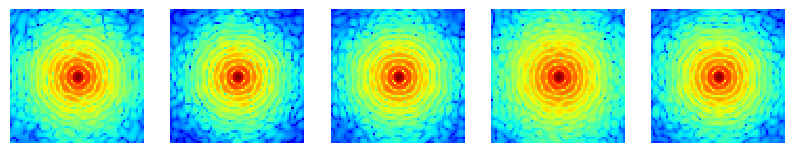

diffraction ground truth


/tmp/ipykernel_682357/1178352548.py:10: RuntimeWarning: divide by zero encountered in log
  vis.display_imgs(np.log(np.absolute(X_test[:, :, :, 0]))[i:i + off])


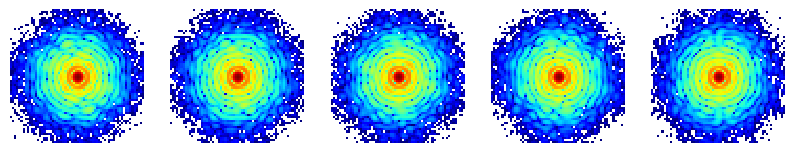

object reconstruction (amp)


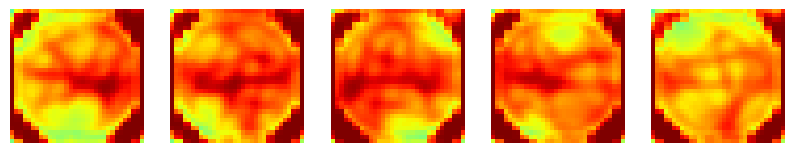

object ground truth


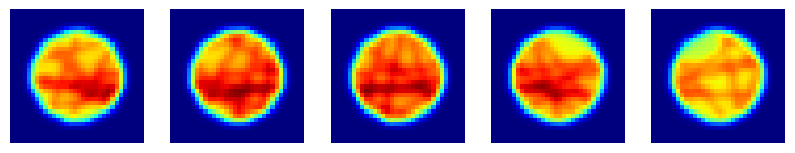

In [40]:
off = 5

vmin = np.min(Y_I_test[:, 16:-16, 16:-16][i:i + off])
vmax = np.max(Y_I_test[:, 16:-16, 16:-16][i:i + off])

print('diffraction reconstruction')
vis.display_imgs(np.log(np.absolute(a[:, :, :, 0]))[i:i + off])

print('diffraction ground truth')
vis.display_imgs(np.log(np.absolute(X_test[:, :, :, 0]))[i:i + off])

print('object reconstruction (amp)')
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16, 0])[i:i + off], vmin = vmin, vmax = vmax)
# print('object reconstruction (phase)')
# vis.display_imgs(np.angle(b[:, 16:-16, 16:-16, 0])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16, 0][i:i + off], vmin = vmin, vmax = vmax)

## save model

In [249]:
history.history.keys()

dict_keys(['loss', 'pred_amplitude_loss', 'padded_obj_loss', 'pred_amplitude_1_loss', 'val_loss', 'val_pred_amplitude_loss', 'val_padded_obj_loss', 'val_pred_amplitude_1_loss', 'lr'])

In [250]:
np.save(path+'str_history', history.history)

In [251]:
# model.load_weights(checkpoint_filepath)

In [68]:
# val_losses=hist.history['val_loss']
# min_epoch=np.argmin(val_losses)+1
# print (min_epoch)
# np.save(path+'%s/min_epoch' %(wt_path), min_epoch)
autoencoder.save('{}.h5'.format(wt_path))